# Visualizing Latent dimesnions

tensor([0.9702, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0230],
       device='cuda:0')
tensor([0.9702, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0230],
       device='cuda:0')
tensor([0.9567, 1.0000, 1.0000, 1.0000, 1.0000, 1.0009, 1.0000, 1.0000, 1.0698],
       device='cuda:0')
tensor([0.9567, 1.0000, 1.0000, 1.0000, 1.0000, 1.0009, 1.0000, 1.0000, 1.0698],
       device='cuda:0')
tensor([0.9871, 0.9650, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0197, 1.0618],
       device='cuda:0')
tensor([0.9871, 0.9650, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0197, 1.0618],
       device='cuda:0')
tensor([0.9906, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0011, 1.0123],
       device='cuda:0')
tensor([0.9906, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0011, 1.0123],
       device='cuda:0')


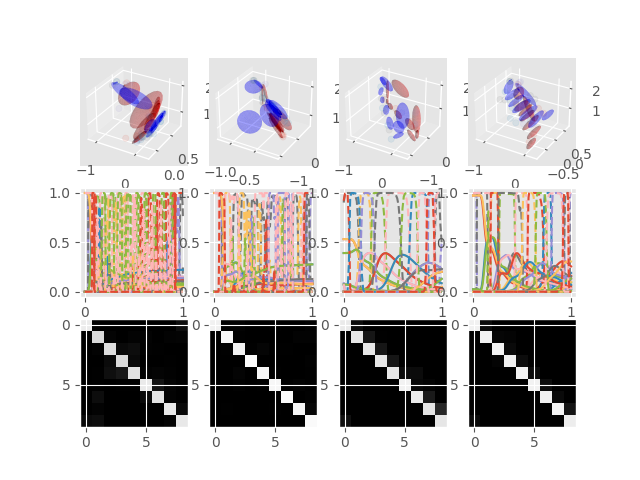

In [3]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from mild_hri.vae import *
import mild_hri.utils
import dataloaders

import pbdlib as pbd
import pbdlib_torch as pbd_torch

import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_path = 'logs/2023/bp_hh_20hz/v1_0/fullhsmm_z3h9/models/final.pth'
ckpt = torch.load(ckpt_path)
# args_ckpt = ckpt['args'].item()
args_ckpt = utils.training_argparse([])
args_ckpt.latent_dim = 3
args_ckpt.hidden_sizes = [40, 20]
args_ckpt.downsample = 0.2
args_ckpt.window_size = 5

model = FullCovVAE(**(args_ckpt.__dict__)).to(device)
model.load_state_dict(ckpt['model'])
model.eval()
z_dim = model.latent_dim

# if args_ckpt.dataset == 'buetepage_pepper':
# 	dataset = dataloaders.buetepage.PepperWindowDataset
# elif args_ckpt.dataset == 'buetepage':
dataset = dataloaders.buetepage.HHWindowDataset
# TODO: Nuitrack

# train_iterator = DataLoader(dataset('./data/buetepage/traj_data.npz', train=True, window_length=20, downsample=0.2), batch_size=1, shuffle=True)
# ssm=[]
# with torch.no_grad():
# 	for a in range(len(train_iterator.dataset.actidx)):
# 		# ssm.append(pbd_torch.ssm(nb_dim=args_ckpt.latent_dim*2, nb_states=args_ckpt.ssm_components))
# 		s = train_iterator.dataset.actidx[a]
# 		z_encoded = []
# 		for j in range(s[0], s[1]):
# 			# for j in np.random.randint(s[0], s[1], 12):
# 			x, label = train_iterator.dataset[j]
# 			x = torch.Tensor(x).to(device)
# 			x_h = x[:, :model.input_dim]
# 			x_r = x[:, model.input_dim:]
			
# 			z_h = model(x_h, encode_only=True)
# 			z_r = model(x_r, encode_only=True)
# 			z_encoded.append(torch.concat([z_h, z_r], dim=-1).cpu().numpy()) # (num_trajs, seq_len, 2*z_dim)
# 		ssm_np = pbd.ssm(nb_dim=model.latent_dim*2, nb_states=5)
# 		# ssm_np.init_hmm_kbins(z_encoded)
# 		ssm_np.init_params_scikit(np.concatenate(z_encoded))
# 		ssm_np.em(z_encoded)
# 		ssm.append(ssm_np)

ssm = ckpt['ssm']

test_dataset = dataset(args_ckpt.src, train=False, window_length=args_ckpt.window_size, downsample=args_ckpt.downsample)
# test_dataset = dataset('./data/buetepage/traj_data.npz', train=False, window_length=5, downsample=0.2)
actions = ['Hand Wave', 'Hand Shake', 'Rocket Fistbump', 'Parachute Fistbump']

fig = plt.figure()
ax_dists = []
ax_alpha= [] 
ax_trans = []
for i in range(4):
	ax_dists.append(fig.add_subplot(3, 4, i+1, projection='3d'))
	ax_alpha.append(fig.add_subplot(3, 4, 4+i+1))
	ax_trans.append(fig.add_subplot(3, 4, 8+i+1))
actidx = np.hstack(test_dataset.actidx - np.array([0,1]))
for a in actidx:
	x, label = test_dataset[a]
	seq_len = x.shape[0]
	dims_h = model.input_dim
	x = torch.Tensor(x).to(device)
	x_h = x[:, :dims_h]
	x_r = x[:, dims_h:]
	
	zh_post = model(x_h, dist_only=True)
	zr_post = model(x_r, dist_only=True)
	ax_dists[label].scatter3D(zh_post.mean[::20, 0].detach().cpu().numpy(), zh_post.mean[::20, 1].detach().cpu().numpy(), zh_post.mean[::20, 2].detach().cpu().numpy(), 'r.', alpha=0.1)
	ax_dists[label].scatter3D(zr_post.mean[::20, 0].detach().cpu().numpy(), zr_post.mean[::20, 1].detach().cpu().numpy(), zr_post.mean[::20, 2].detach().cpu().numpy(), 'b.', alpha=0.1)

	# alpha = ssm[label].forward_variable(marginal=[], sample_size=100)#.detach().cpu().numpy()
	# alpha_h = ssm[label].forward_variable(demo=zh_post.mean.detach().cpu().numpy(), marginal=slice(0, z_dim))#.detach().cpu().numpy()
	alpha, _, _, _, _ = ssm[label].compute_messages(marginal=[], sample_size=seq_len)
	alpha_h, _, _, _, _ = ssm[label].compute_messages(demo=zh_post.mean, marginal=slice(0, z_dim))
	ax_alpha[label].plot(np.linspace(0, 1, seq_len), alpha.T.detach().cpu().numpy(), linestyle='-')
	ax_alpha[label].plot(np.linspace(0, 1, seq_len), alpha_h.T.detach().cpu().numpy(), linestyle='--')

	print(ssm[label].Trans.sum(0))
	ax_trans[label].imshow(np.tile(ssm[label].Trans[..., None].detach().cpu().numpy(), (1,1,3)))#.detach().cpu().numpy())
	
	for i in range(ssm[label].nb_states):
		pbd.plot_gauss3d(ax_dists[label], ssm[label].mu[i, :3].detach().cpu().numpy(), ssm[label].sigma[i, :3, :3].detach().cpu().numpy(),
					color='red', alpha=0.1)
		pbd.plot_gauss3d(ax_dists[label], ssm[label].mu[i, z_dim:z_dim+3].detach().cpu().numpy(), ssm[label].sigma[i, z_dim:z_dim+3, z_dim:z_dim+3].detach().cpu().numpy(),
					color='blue', alpha=0.1)
		
	# break
